In [1]:
%matplotlib inline
from CartPole import CartPole, remap_angle, _remap_angle, _loss, loss, generate_data, move_cart, plot_y_contour_as_difference_in_x, plot_y_scans, range_x_pair_finder
import autograd.numpy as np
from matplotlib.pyplot import ion, draw, Rectangle, Line2D
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from sklearn import linear_model
import cmath

# Week 1

In [2]:
plot_path = 'plots/Task2/' # because now using action which is in task 2
plot_path_1 = 'plots/Task1/'

In [3]:
initial_x = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15), np.random.uniform(-20,20)])
print(initial_x)

index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity', 4 : 'action'}
list_of_index_pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
no_samples = 20
x_range_for_index = {0 : np.linspace(-5,5,no_samples), 1 : np.linspace(-10,10,no_samples), 2 : np.linspace(-np.pi,np.pi,no_samples), 3 : np.linspace(-15,15,no_samples)}

remap_angle = True

[  0.43434375   7.62239026   2.00621212  -1.04597885 -16.90566902]


## Task 1.1

### Simple oscillation around stable equilibrium

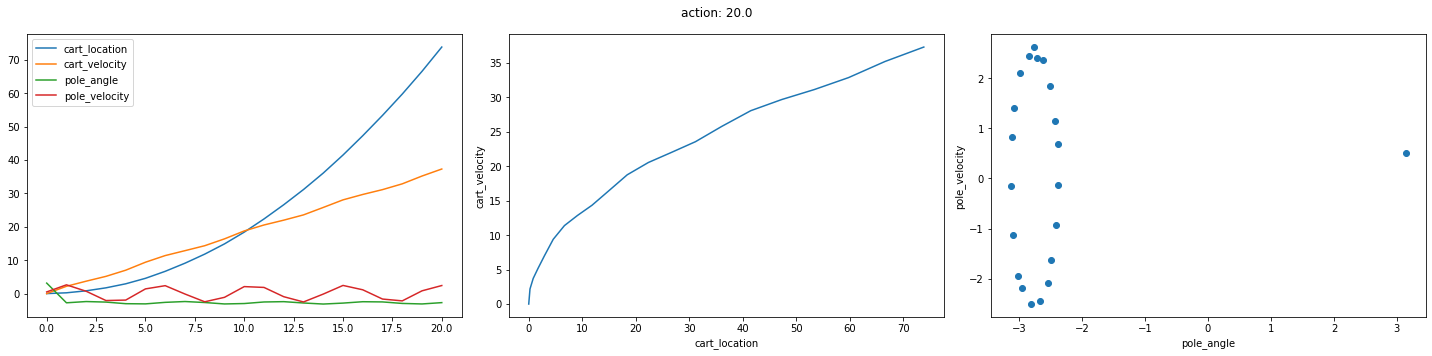

In [4]:
history = move_cart([0,0,np.pi,0.5, 20.0], steps=20, remap_angle=remap_angle)
# plt.savefig(plot_path + 'rollout_stable_equilibrium_with_action')

### Complete rotation of pendulum

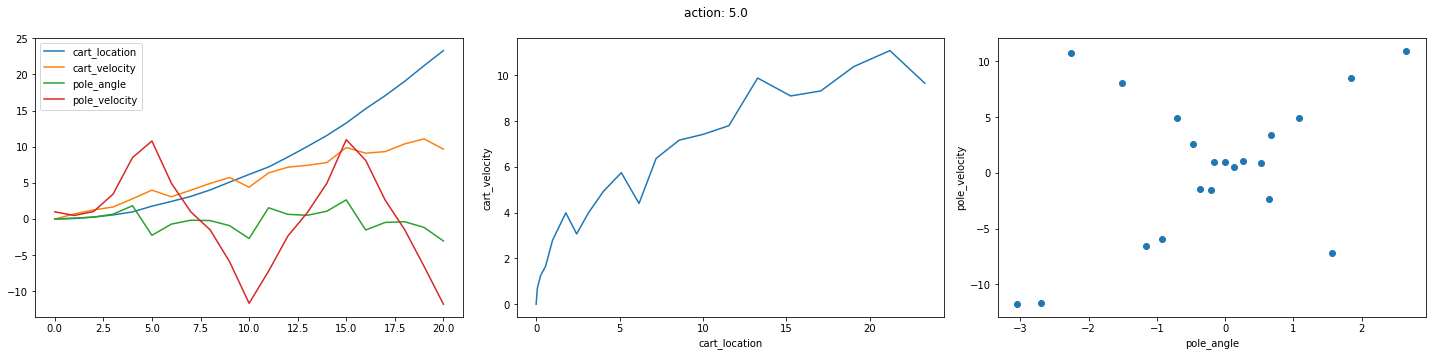

In [5]:
history = move_cart([0,0,0,1, 5.0], steps=20, remap_angle=remap_angle)
# plt.savefig(plot_path + 'rollout_complete_rotation_with_action')

This is clearly a complete rotation, but the pole doesn't seem to ever hit 2pi because the pole angle is only sampled at discrete intervals therefore a value of exactly 2pi will never be recorded.

## Task 1.2

In [6]:
def plot_y():
    '''
    function for plotting y values when y is modelled 
    as X after one PerformAction step
    
    Parameters
    ----------
    index : int
        Which index of X (or variable) to scan over
    range_x : list-like
        Scan range
    '''

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    for index in range(4):
        
        range_x = x_range_for_index[index]
        
        x = initial_x.copy()
        y_results = []
        
        for i in range_x:
            x[index] = i
            y = move_cart(x, steps=1, display_plots=False, remap_angle=remap_angle)
            y_results.append(y)
            
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[0] for y in y_results], label='cart_location')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[1] for y in y_results], label='cart_velocity')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[2] for y in y_results], label='pole_angle')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[3] for y in y_results], label='pole_velocity')
        axs[int(round((index+1)/4,0)),index%2].set_ylabel('component of y values')
        axs[int(round((index+1)/4,0)),index%2].set_xlabel('{} initial values'.format(index_to_variable[index]))
        axs[int(round((index+1)/4,0)),index%2].legend()
        
    fig.tight_layout()

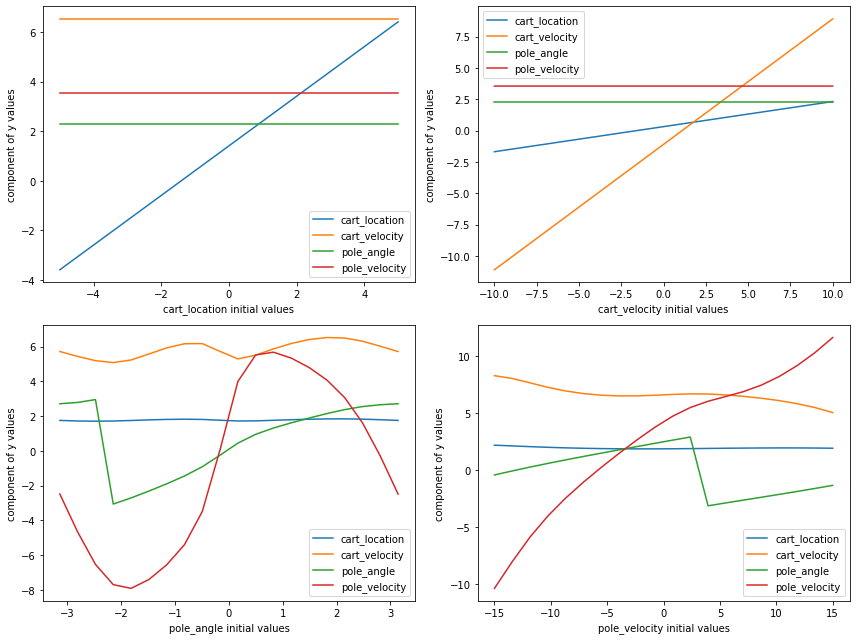

In [7]:
plot_y()
# plt.savefig(plot_path + 'y_as_next_step_with_action')

The above plots are of Y modelled as X after one PerformAction

#### Modelling Y using Y = X(T) - X(0)

##### (i) scans of single variables

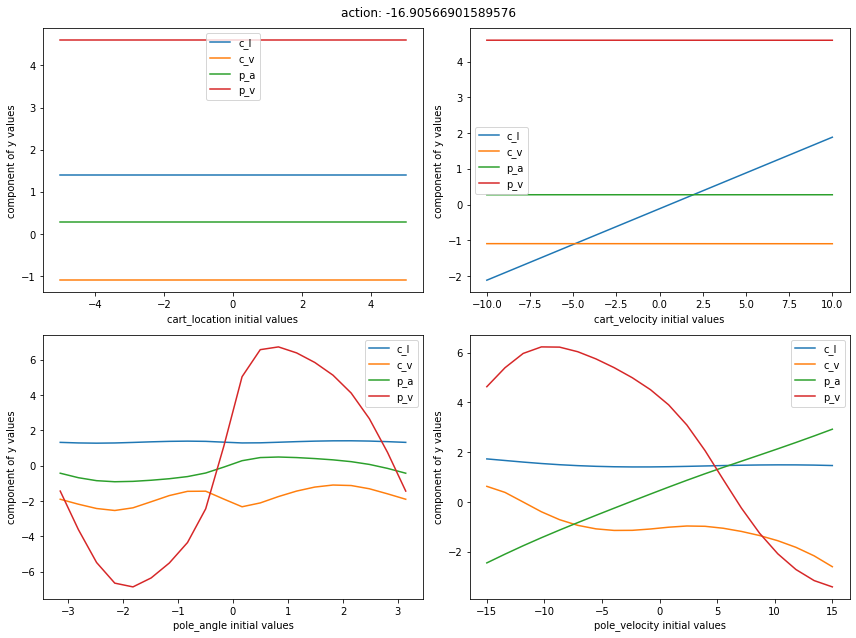

In [8]:
plot_y_scans(initial_x, index_to_variable, x_range_for_index)
# plt.savefig(plot_path + 'y_as_difference_scan_1_with_action')

##### (ii) contour plots

In [9]:
# for index_pair in list_of_index_pairs:
#     print('_____________________Plots of {} vs {}_____________________'.format(index_to_variable[index_pair[0]],index_to_variable[index_pair[1]]))
#     plot_y_contour_as_difference_in_x(initial_x, index_pair, range_x_pair_finder(index_pair, x_range_for_index), index_to_variable)
# #     if index_pair == [0,1]: plt.savefig(plot_path + 'contour_plot_scan_over_{}_{}_with_action'.format(index_pair[0], index_pair[1]))
#     plt.show()
#     plt.close()

From these plots, we can see that:
1. Initial values that affect Y linearly are:

    Cart location

    Cart velocity


2. Initial values that affect Y non-linearly are:

    Pole angle
    
    Pole velocity
    

Clearly the cart location does not affect any of these Y values. 


## Task 1.3

In [10]:
proportion_train = 0.6
n = 500
train_index = int(proportion_train*n)

x,y = generate_data(500)

x_train, y_train = x[:train_index], y[:train_index]
x_test, y_test = x[train_index:], y[train_index:]

x.shape,y[:,0].shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((500, 5), (500,), (300, 5), (300, 5), (200, 5), (200, 5))

In [11]:
def predict(x_train, y_train, x_test):
    B = np.matmul(np.linalg.pinv(x_train),y_train)
    print(np.abs(np.linalg.eig(B)[0]))
    pred = np.matmul(x_test,B)
    return pred
    
predictions = predict(x_train, y_train, x_test)

[0.         0.52350749 0.47214668 0.05769968 0.05769968]


In [12]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

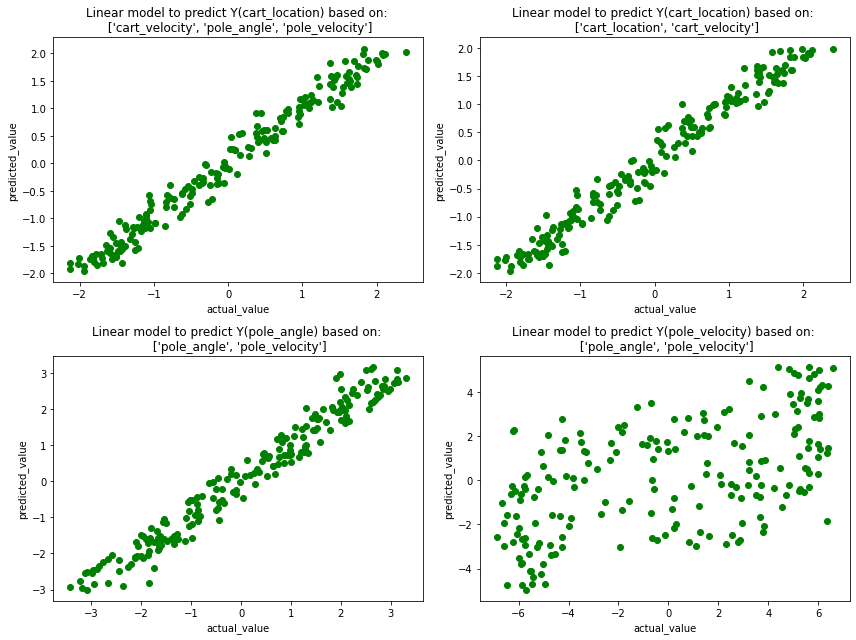

In [13]:
list_test_indices_and_output = [[1,2,3,0],[0,1,0],[2,3,2],[2,3,3]]
number_plots = len(list_test_indices_and_output)

fig, axs = plt.subplots((number_plots//2), 2, figsize=(12, 4.5*(number_plots//2)))
for i,indice_and_output in enumerate(list_test_indices_and_output):
    indices = indice_and_output[:-1]
    output = indice_and_output[-1]
    reg_ = linear_model.LinearRegression()
    reg_.fit(x_train[:,indices], y_train[:,output])
    for x,y in zip(x_test,y_test):
        pred = reg_.predict([x[indices]])
        axs[int(round((i+1)/4,0)),i%2].scatter(y[output], pred, color='g')
        axs[int(round((i+1)/4,0)),i%2].set_xlabel('actual_value')
        axs[int(round((i+1)/4,0)),i%2].set_ylabel('predicted_value')
        axs[int(round((i+1)/4,0)),i%2].set_title('Linear model to predict Y({}) based on: \n {}'.format(index_to_variable[output], str([index_to_variable[index] for index in indices])))
    fig.tight_layout()

# plt.savefig(plot_path + 'linear_regression_model_different_inputs')

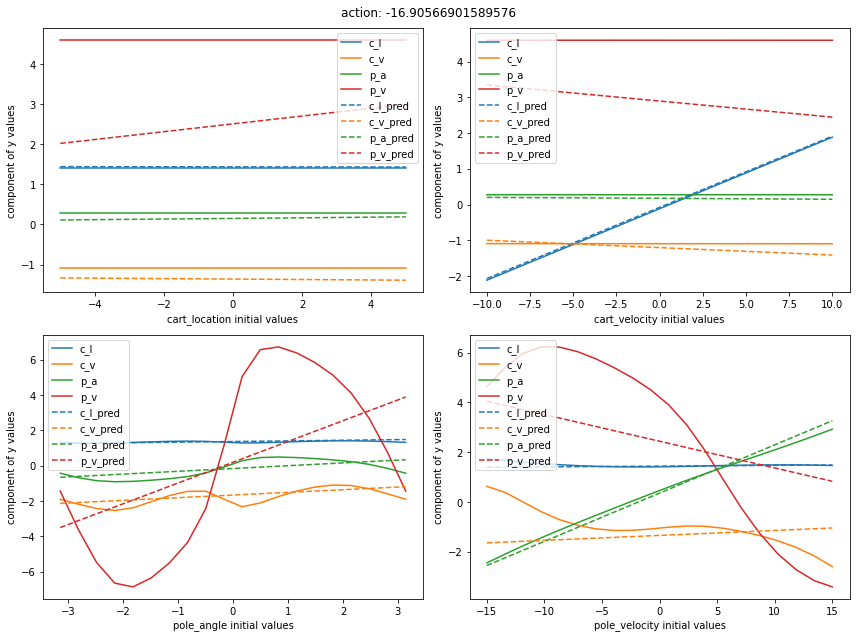

In [14]:
plot_y_scans(initial_x, index_to_variable, x_range_for_index, model=reg)
# plt.savefig(plot_path_1 + 'linear_regression_predictions_for_y_scanning_1')

# Task 1.4

In [15]:
def project_x_using_linear_model(initial_x, linear_model, steps, remap_angle=True):
    
    cp = CartPole()
    cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity, action = initial_x
    pred_ = None
    
    for step in range(steps):
        x_ = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity, action]
        cp.performAction(action)
        if remap_angle: cp.remap_angle()
        y_ = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity, action]
        if pred_ is not None: 
            pred_ = x_ + linear_model.predict([x_])
            if remap_angle: 
                pred_[0][2] = _remap_angle(pred_[0][2])    
        try:
            prediction_history = np.vstack((prediction_history, pred_))
            y_history = np.vstack((y_history, y_))
        except:
            assert all(x_) == all(initial_x), '{}_______{}'.format(x_, initial_x)
            pred_ = x_ + linear_model.predict([x_])
            prediction_history = np.vstack((x_, pred_))
            y_history = np.vstack((x_, y_))
            
    return prediction_history, y_history

In [16]:
def plot_prediction_vs_actual_over_time(prediction_history, y_history, title=None, filename=''):
    
    t = range(len(prediction_history))
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].plot(t, [y[0] for y in y_history], label='actual values')
    axs[0,0].plot(t, [pred[0] for pred in prediction_history], label='predicted values')
    axs[0,0].set_ylabel('Y_cart_location')
    axs[0,0].set_xlabel('time_step')    
    axs[0,1].plot(t, [y[1] for y in y_history], label='actual values')
    axs[0,1].plot(t, [pred[1] for pred in prediction_history], label='predicted values')
    axs[0,1].set_ylabel('Y_cart_velocity')
    axs[0,1].set_xlabel('time_step')    
    axs[1,0].plot(t, [y[2] for y in y_history], label='actual values')
    axs[1,0].plot(t, [pred[2] for pred in prediction_history], label='predicted values')
    axs[1,0].set_ylabel('Y_pole_angle')
    axs[1,0].set_xlabel('time_step')
    axs[1,1].plot(t, [y[3] for y in y_history], label='actual values')
    axs[1,1].plot(t, [pred[3] for pred in prediction_history], label='predicted values')
    axs[1,1].set_ylabel('Y_pole_velocity')
    axs[1,1].set_xlabel('time_step')
    axs[0,1].legend(loc='upper right')
    if title: fig.suptitle(title)
    fig.tight_layout()
#     plt.savefig(plot_path + 'linear_regression_model_{}_remap={}'.format(filename, remap_angle))
    

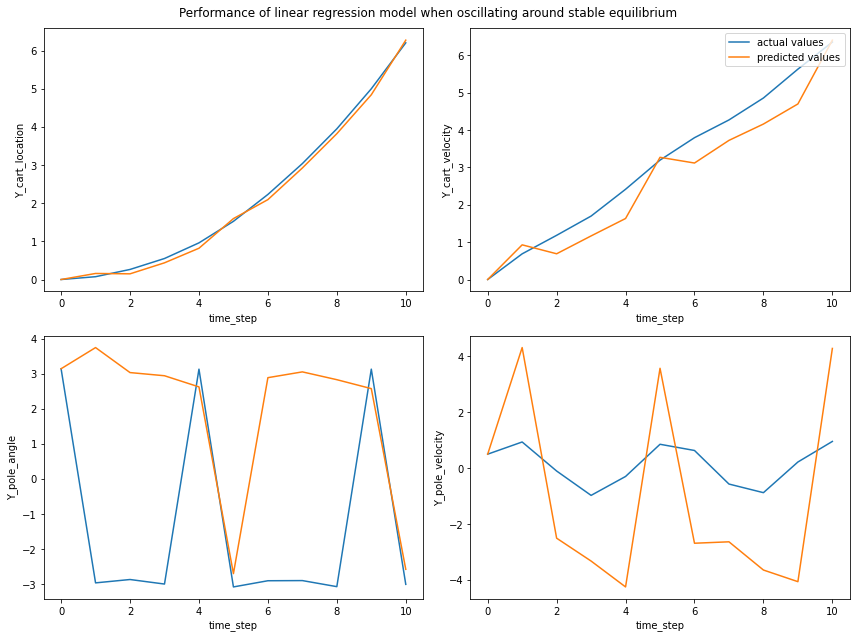

In [17]:
prediction_history, y_history = project_x_using_linear_model([0,0,np.pi,0.5, 5.0], reg, 10)
plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Performance of linear regression model when oscillating around stable equilibrium', filename='SHM_compound_pred')
# plt.savefig(plot_path + 'linear_model_predictions_with_action_stable_equilibrium')

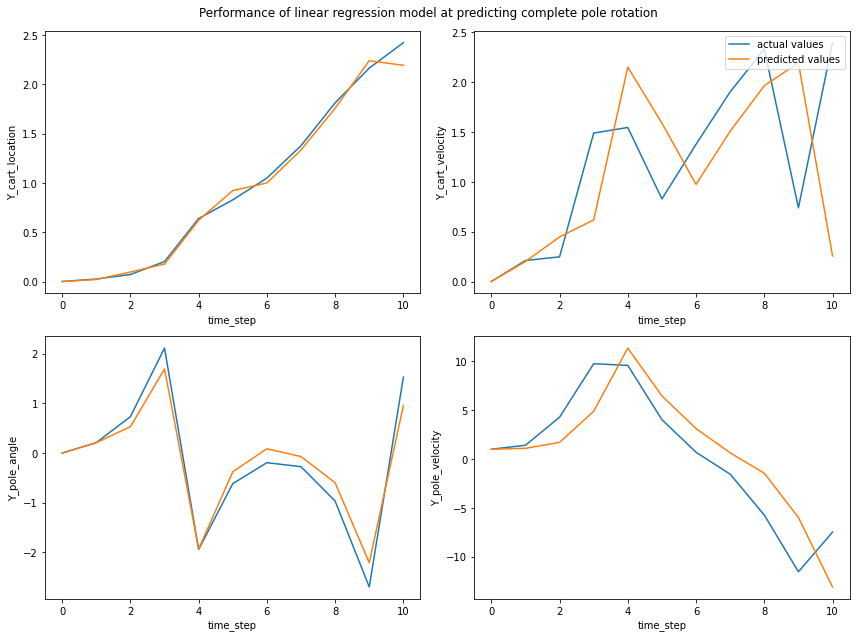

In [18]:
prediction_history, y_history = project_x_using_linear_model([0,0,0,1, 2.0], reg, 10)
plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Performance of linear regression model at predicting complete pole rotation', filename='complete_rotation_compound_pred')
# plt.savefig(plot_path + 'linear_model_predictions_with_action_complete_rotation')

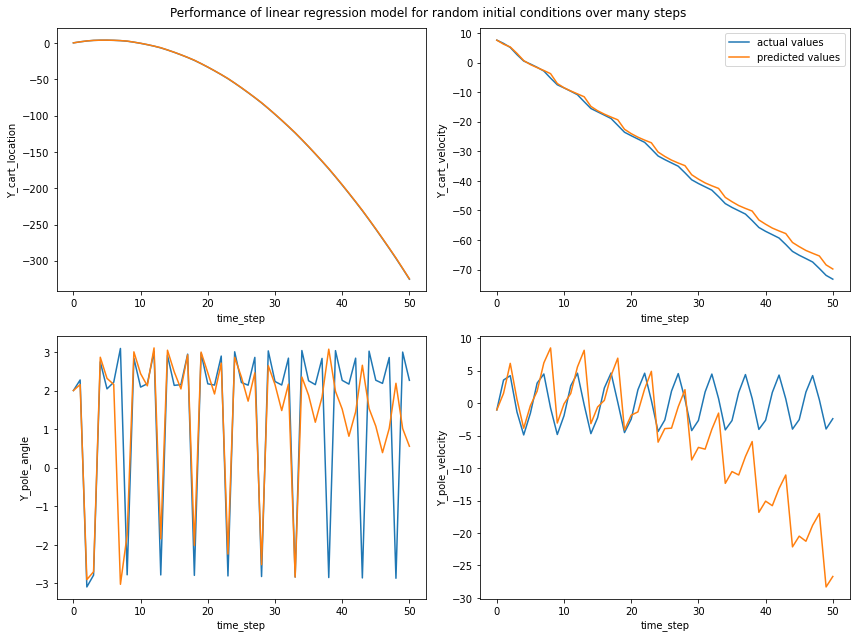

In [19]:
prediction_history, y_history = project_x_using_linear_model(initial_x, reg, 50)
plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Performance of linear regression model for random initial conditions over many steps', filename='random_initial_conditions_many_steps_compound_pred')
# plt.savefig(plot_path + 'linear_model_predictions_with_action_random_init_cond')